In [1]:
# import the Libraries 
import numpy as np
import pandas as pd

#Maths stats
from numpy import mean, std
from math import sqrt
from scipy import stats
from datetime import date,timedelta
import datetime as dt

#data visualisation
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance
from dython.model_utils import roc_graph
from dython.nominal import associations

# data preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples

import umap.umap_ as umap
from sklearn.decomposition import PCA
import scipy.spatial.distance as ssd 

# ML algortihms clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch


# Module perso : helpers
import helpers # Le module du fichier python helper.py
import PCA_NR # Module avec fonctions de Nicolas Rangeon cours Openclassrooms 

from tqdm import tqdm

pd.set_option("display.max_rows", 5000)
pd.options.display.max_columns = 999
pd.set_option("display.precision", 4)
pd.options.display.float_format = '{:.2f}'.format # to make legible
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
from IPython.core.display import HTML 

# <span class="bg-primary">Apprentissage non supervisé<span>
# <span class="bg-primary">Clustering - Partie 1 - K-means - Méthode agglomérative ascendante<span>

# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__
    
Fournir aux équipes d'OLIST, entreprise du e-commerce, une __segmentation des clients__ afin qu'elles puissent l'utiliser dans leurs campagnes de communication :
    
- Comprendre les différents types d'utilisateurs (comportements, données personnelles)
- Fournir une description actionable de la segmentation
- Proposer un contrat de maintenance

# <span class="bg-danger">Sommaire<span>
    
__<span class="bg-info">1.<span>__ __Chargement de la table indicateurs clients__
___       
__<span class="bg-info">2.<span>__ __Préparation : données centrées et réduites__
___
__<span class="bg-info">3.<span>__ __ACP__ Analyse en Composantes Principales
___
__<span class="bg-info">4.<span>__ __ACP et K-means__
___    
__<span class="bg-success">4_1.<span>__ __Recherche du nombre de groupe (k) optimal__
___ 
__<span class="bg-warning">4_1_1.<span>__ Méthode du coude
___ 
__<span class="bg-warning">4_1_2.<span>__ Coefficient de silhouette
___ 
__<span class="bg-warning">4_1_3.<span>__ Indice de Davies-Bouldin
___ 
__<span class="bg-warning">4_1_4.<span>__ Conclusions sur le nombre de groupe (k) optimal
___ 
__<span class="bg-success">4_2.<span>__ __Segmentation avec K-means__ 
___ 
__<span class="bg-warning">4_2_1.<span>__K means - Nombre de clusters k = 3
___ 
__<span class="bg-warning">4_2_2.<span>__K means - Nombre de clusters k = 4
___ 
__<span class="bg-warning">4_2_3.<span>__K means - Nombre de clusters k = 5    
___
__<span class="bg-success">4_3.<span>__ __Interpétation des clusters__
___
__<span class="bg-warning">4_3_1.<span>__Interprétation : K means - Nombre de clusters k = 3
___ 
__<span class="bg-warning">4_3_2.<span>__Interprétation : K means - Nombre de clusters k = 4
___ 
__<span class="bg-warning">4_3_3.<span>__Interprétation : K means - Nombre de clusters k = 5       
___    
__<span class="bg-info">5.<span>__ __Méthode hiérarchique ascendante - Essai__

# <span class="bg-info"> 1. Chargement de la table indicateurs clients<span>

In [2]:
# Chargement de la table indicateurs clients
df_clients = pd.read_csv('data_clients_olist.csv')
df_essai = df_clients.copy()
# Suppression colonnes
df_clients.drop('order_purchase_timestamp', axis = 1, inplace = True)
df_clients.set_index('customer_unique_id', inplace=True)

In [3]:
# Suppression colonnes qualitatives en vue de l'ACP
df_clients.drop(['moyen_paiement_prefere', 'catégorie_+_achetée'] , axis = 1, inplace = True)

# <span class="bg-info"> 2. Préparation : données centrées et réduites<span>

Classiquement, on s’arrange pour transformer nos variables pour que :
- 1. __leur moyenne soit égale à 0__ (centrage)
- 2. __leur variance soit égale à 1.__ (réduction)
    
### Centrage

La première opération s’appelle __le centrage__. Pour effectuer un centrage sur des observations, il faut soustraire à toutes ces observations leur moyenne.

### Réduction

Après avoir centré les données, __si on les divise par leur écart-type (l’écart-type est la racine carrée de la variance)__, alors on obtient des valeurs dont la variance vaut 1.

In [4]:
# préparation des données pour l'ACP
X = df_clients.values
features = df_clients.columns

# Centrage et Réduction
#Nous mettons à l'échelle les données afin de garantir que Les unités des variables n'ont pas d'impact sur les distances
std_scale = StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# <span class="bg-info"> 3. Réduction de dimension : ACP<span>

In [5]:
pca = PCA()
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

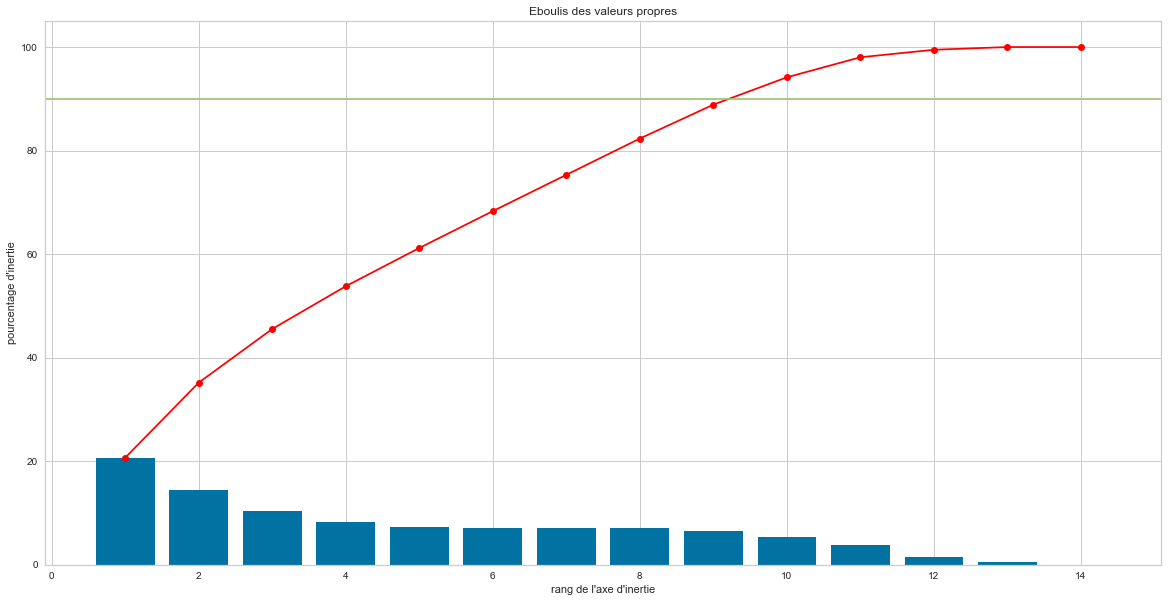

In [6]:
# Eboulis des valeurs propres
PCA_NR.display_scree_plot(pca)

In [7]:
n_comp = 9
pca = PCA(n_components = n_comp)
pca.fit(X_scaled)
X_projected = pca.transform(X_scaled)

In [8]:
df_clients_PCA = pd.DataFrame(X_projected, index = df_clients.index, columns = ["F"+str(i+1)for i in range(9)])
df_clients_PCA.shape

(91133, 9)

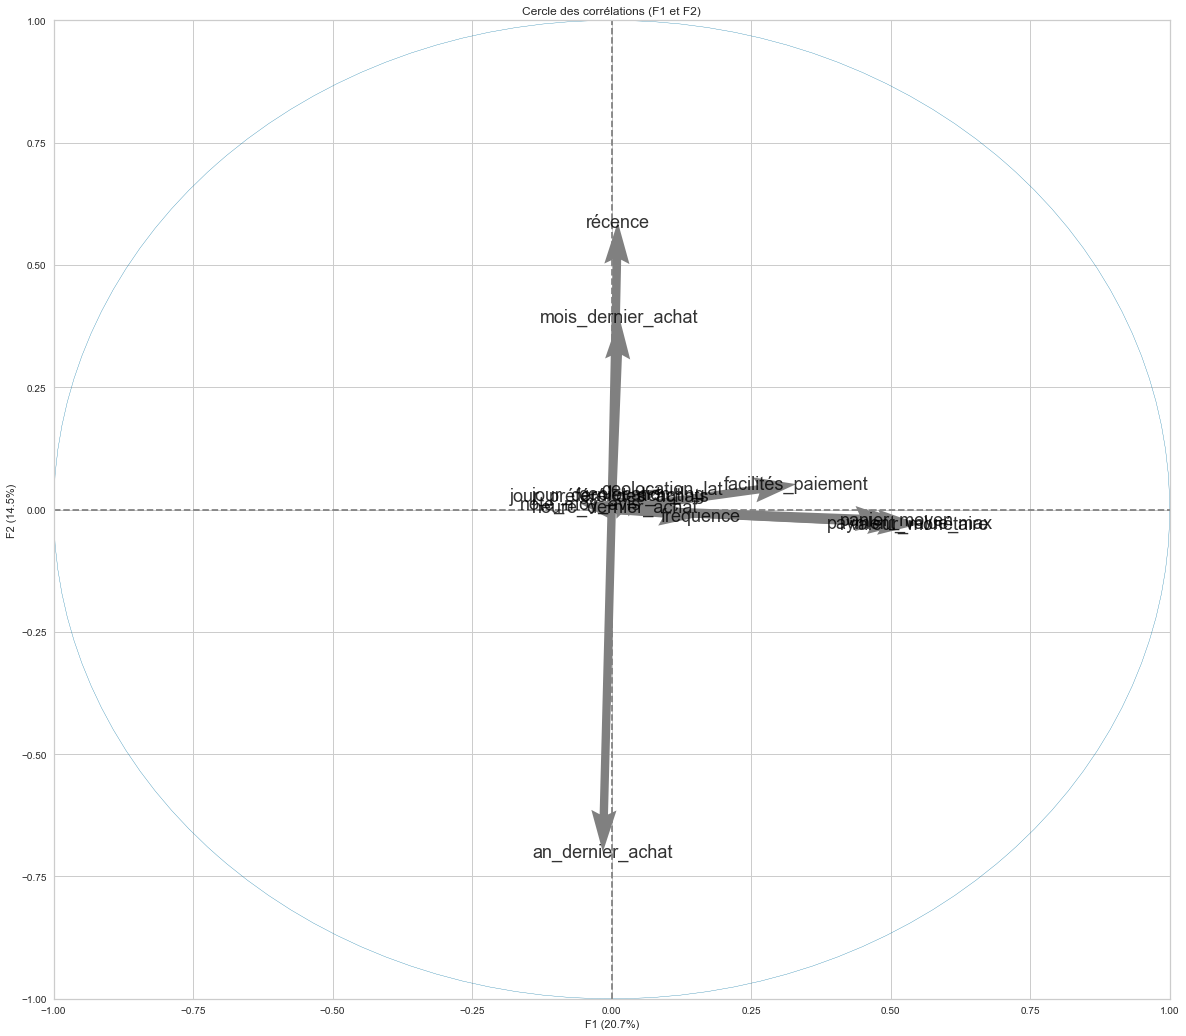

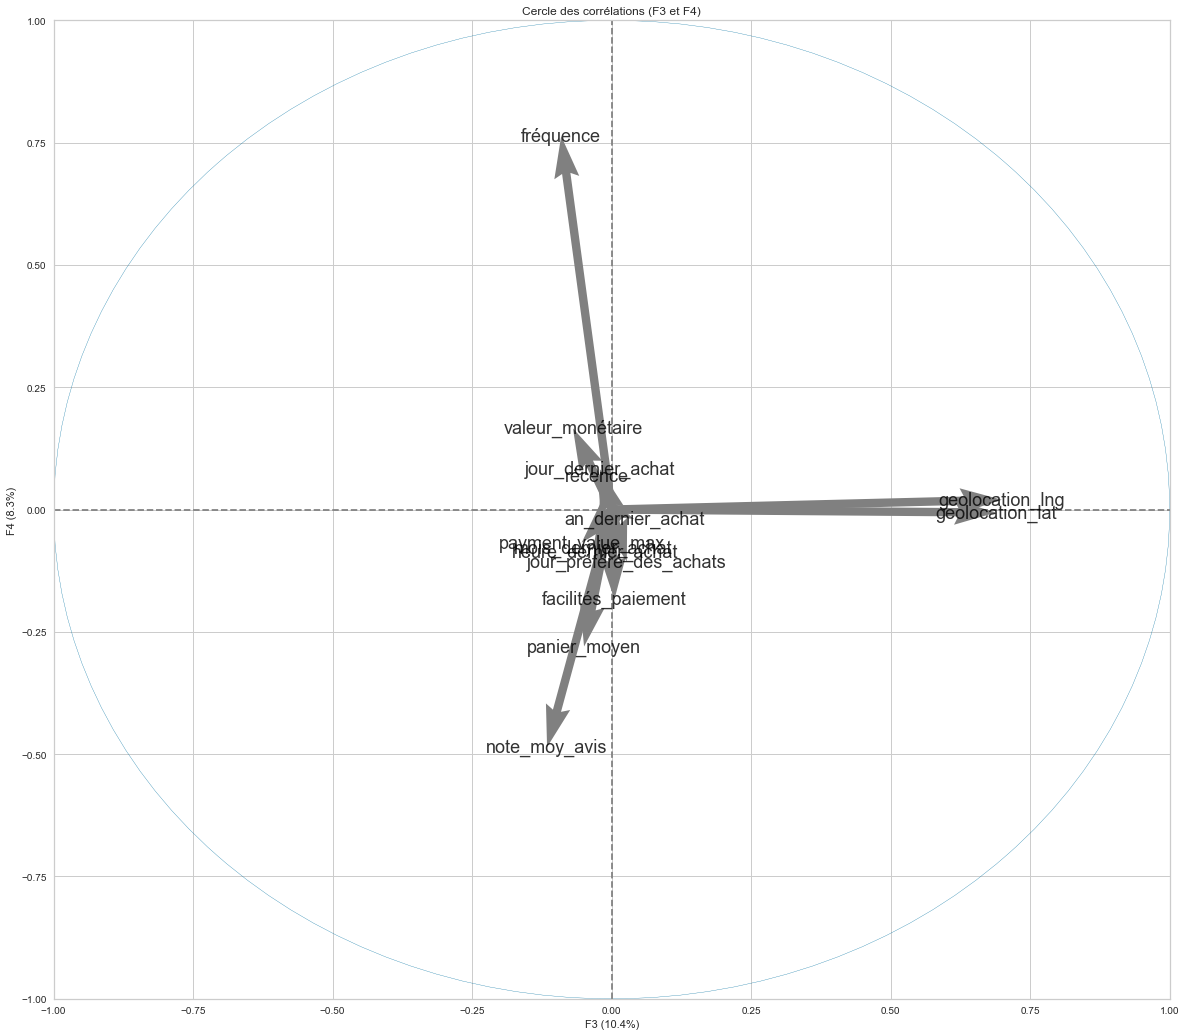

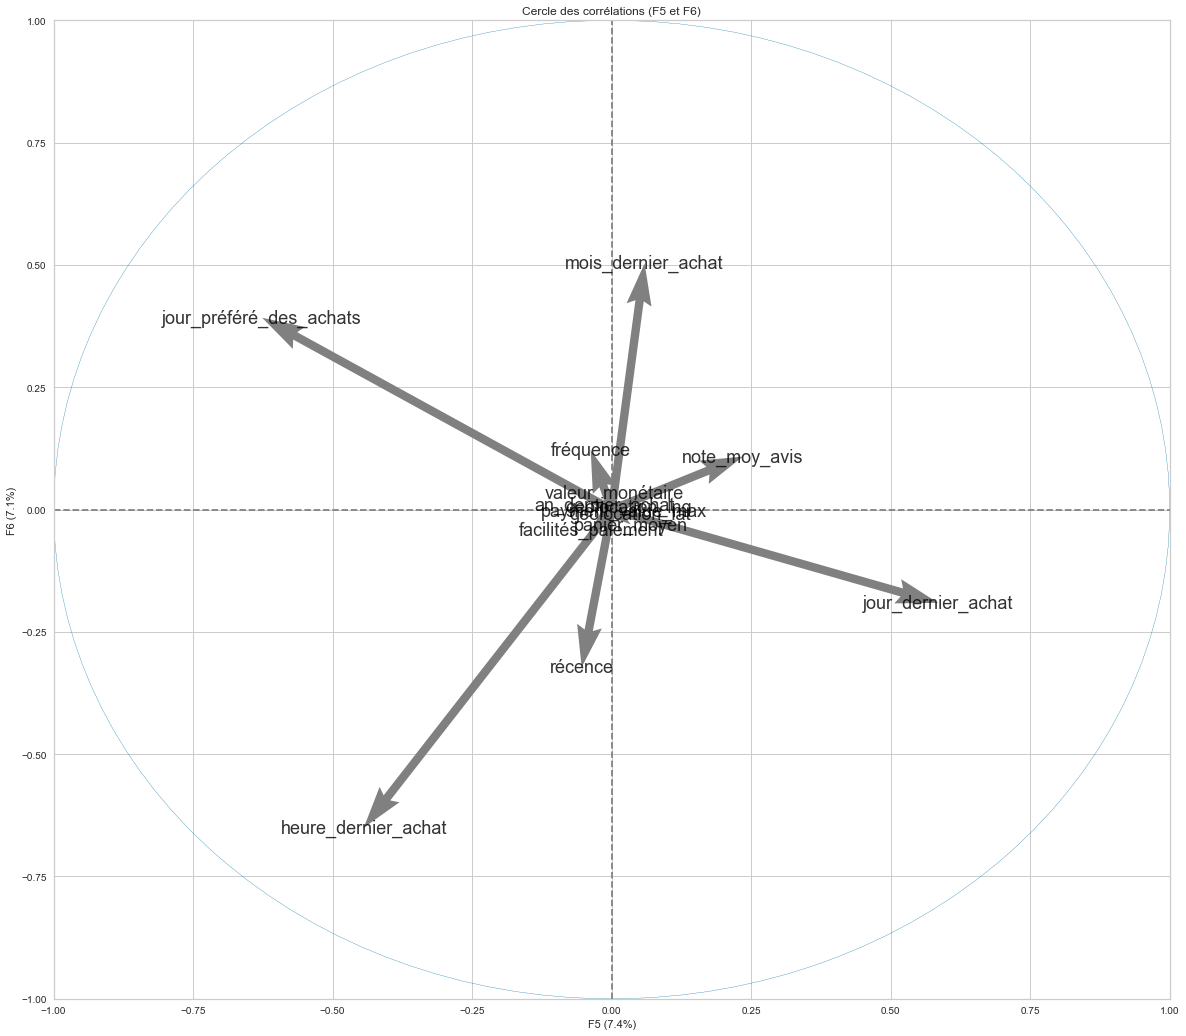

In [9]:
# Cercle des corrélations
pcs = pca.components_
PCA_NR.display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features)) # Plan factoriel pour les 2 premières composantes de l'ACP 
PCA_NR.display_circles(pcs, n_comp, pca, [(2,3)], labels = np.array(features)) # Plan factoriel pour les composantes 3 et 4 de l'ACP 
PCA_NR.display_circles(pcs, n_comp, pca, [(4,5)], labels = np.array(features)) # Plan factoriel pour les composantes 5 et 6 de l'ACP 

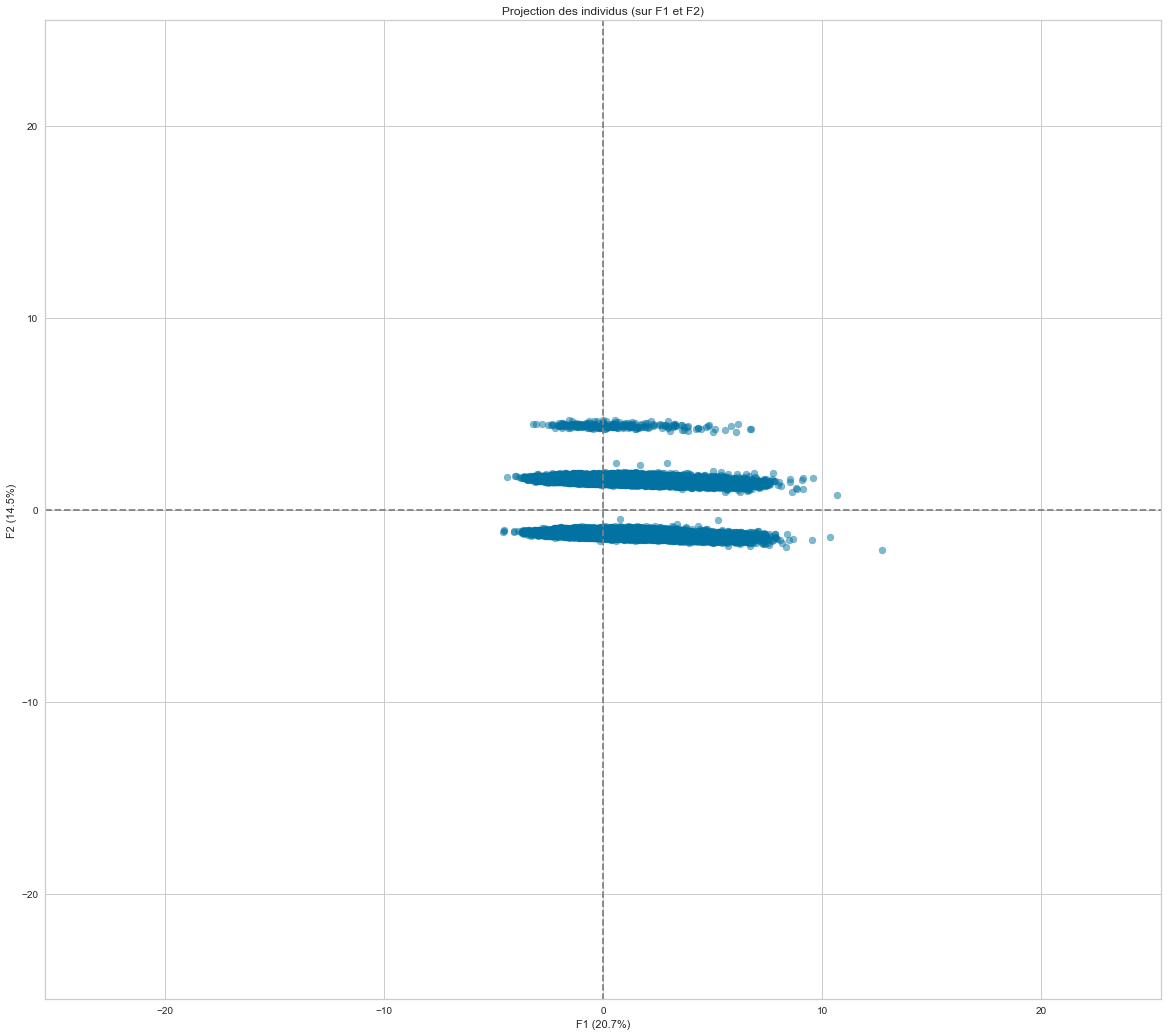

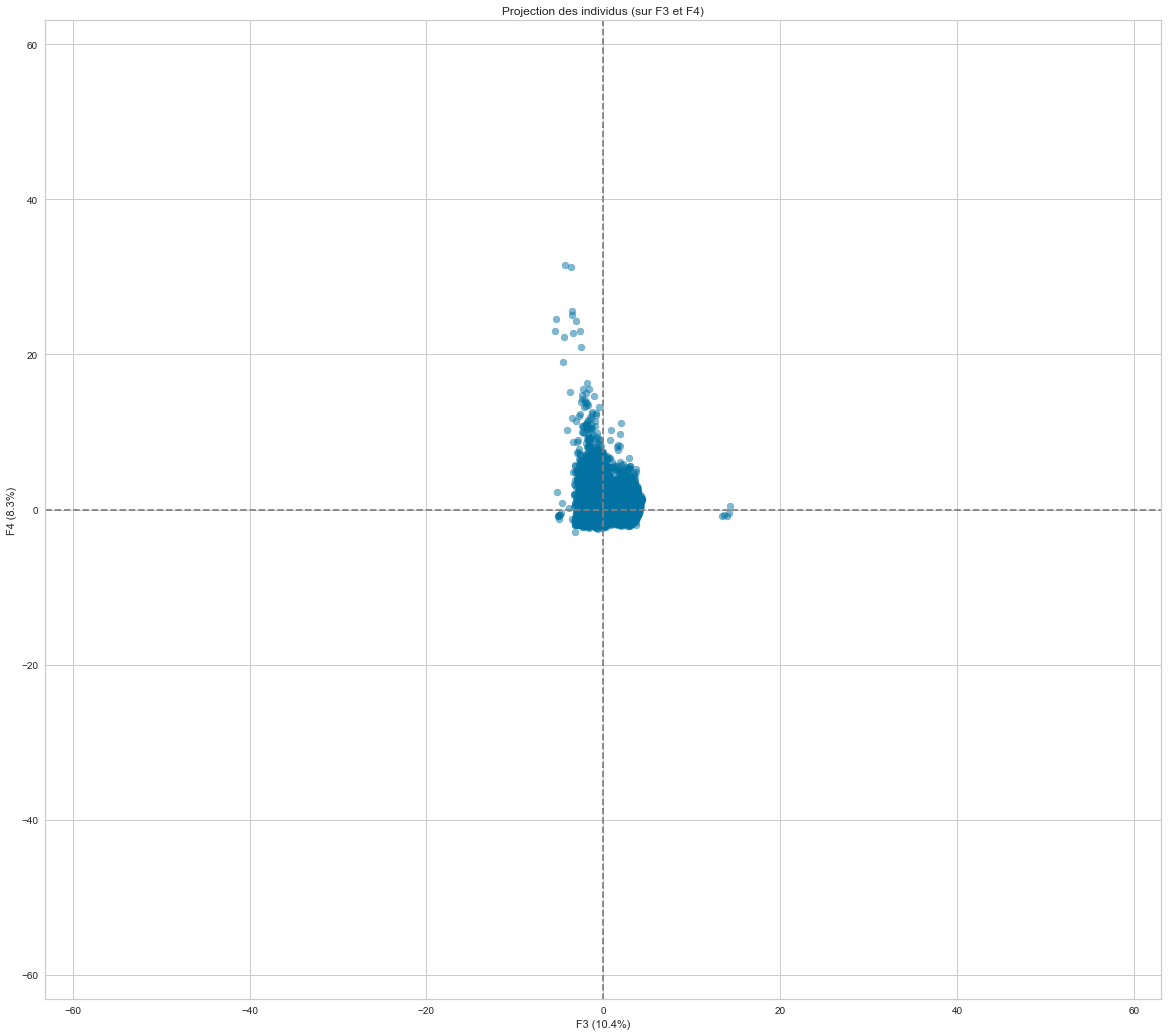

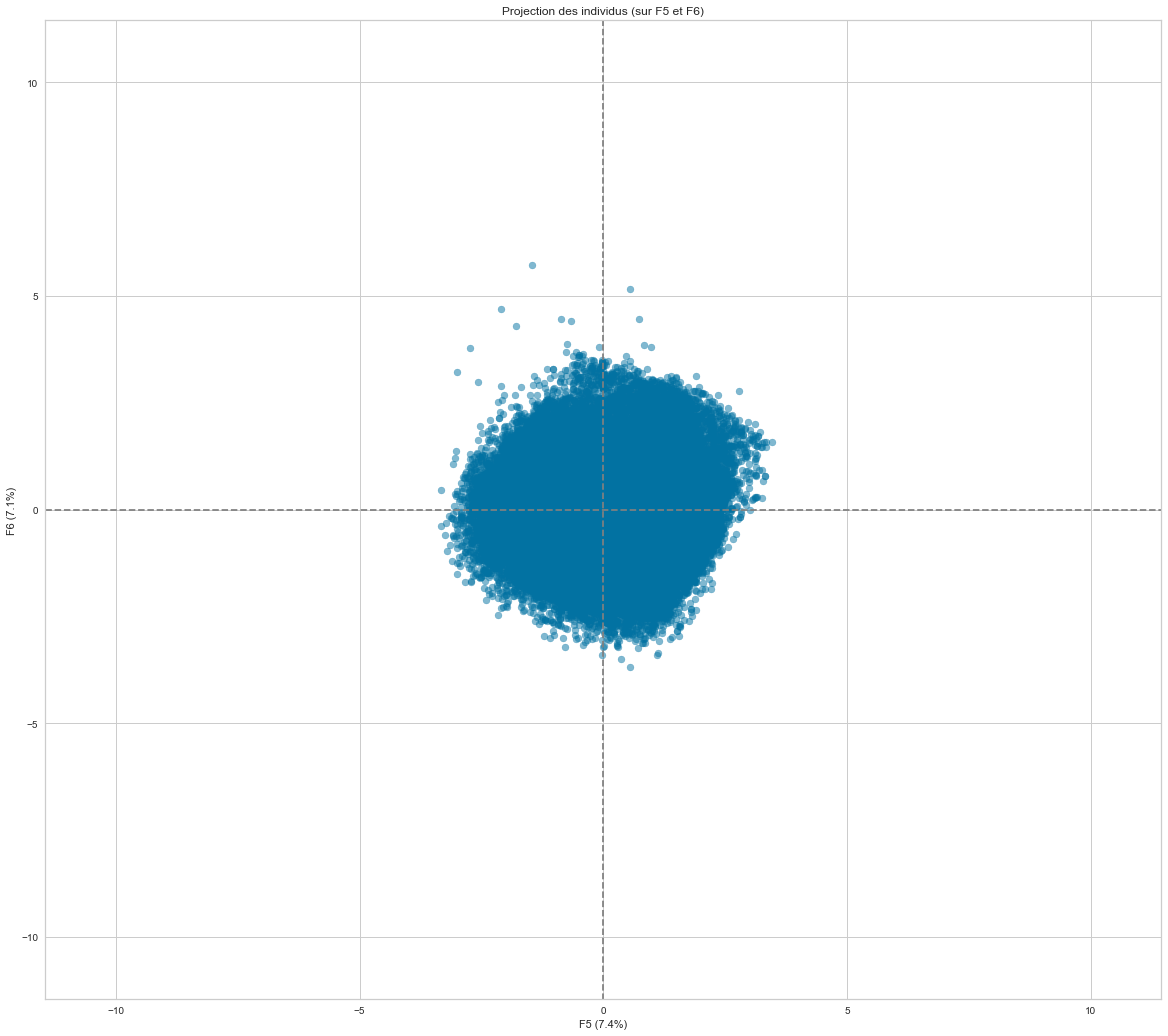

In [10]:
# Projection des individus
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.5)

# <span class="bg-info"> 4. ACP et K-means<span> 
L’attribut n_clusters de la classe KMeans de Scikit-Learn permet de fixer le nombre de centroïdes que l’on souhaite. Par conséquent elle définit aussi le nombre de centroïdes initiaux. Cette classe utilise par défaut non pas une méthode d’initialisation aléatoire mais une méthode développée en 2007 par David Arthur et Sergei Vassilvitskii dénommée K-MEANS ++. Elle consiste à sélectionner des centroïdes distincts les uns des autres ce qui limite les risques de convergence vers une solution non-optimale. La distance par défaut utilisée est la distance euclidienne.    

## <span class="bg-success"> 4.1 Recherche du nombre de groupes (clusters) k optimal<span>
- __Methode dite "du coude"__
- __Coefficient de silhouette__
- __Indice de Davies Bouldin__

In [11]:
km_scores= []
km_silhouette = []
db_score = []
for i in tqdm(range(2,7)):
    km = KMeans(n_clusters=i, random_state=0).fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))

  0%|          | 0/5 [00:00<?, ?it/s]

Score for number of cluster(s) 2: -1093180.2803677921


 20%|██        | 1/5 [01:11<04:46, 71.74s/it]

Silhouette score for number of cluster(s) 2: 0.16337679741189948
Davies Bouldin score for number of cluster(s) 2: 2.286919654241233
Score for number of cluster(s) 3: -973917.0198935043


 40%|████      | 2/5 [02:21<03:33, 71.05s/it]

Silhouette score for number of cluster(s) 3: 0.15913774364868888
Davies Bouldin score for number of cluster(s) 3: 1.9857648809257296
Score for number of cluster(s) 4: -916575.3065346482


 60%|██████    | 3/5 [03:30<02:20, 70.42s/it]

Silhouette score for number of cluster(s) 4: 0.1623977127289626
Davies Bouldin score for number of cluster(s) 4: 1.856206048505781
Score for number of cluster(s) 5: -874423.2291566457


 80%|████████  | 4/5 [04:38<01:09, 69.75s/it]

Silhouette score for number of cluster(s) 5: 0.11611763237250992
Davies Bouldin score for number of cluster(s) 5: 2.0830851579743146
Score for number of cluster(s) 6: -836689.9736032927


100%|██████████| 5/5 [05:46<00:00, 69.23s/it]

Silhouette score for number of cluster(s) 6: 0.11164576714459837
Davies Bouldin score for number of cluster(s) 6: 2.223863746187392


### <span class="bg-warning"> 4.1.1 Méthode "du coude"<span>

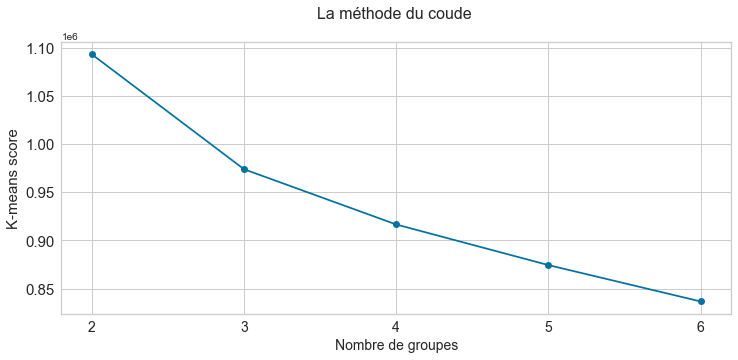

In [12]:
plt.figure(figsize=(12,5))
plt.title("La méthode ""du coude"" ""\n",fontsize=16)
plt.plot([i for i in range(2,7)],km_scores, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de groupes",fontsize=14)
plt.ylabel("K-means score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('methode_du_coude_Km.png')
plt.show()

### <span class="bg-warning"> 4.1.2 Coefficient de silhouette<span> 

Il utilise à la fois __le concept de cohésion et de séparation.__ 

__Ce coefficient peut varier entre -1 et +1.__

- Un __coefficient proche de +1__ signifie que l’observation est située bien à l’intérieur de son propre cluster, 
- un __coefficient proche de 0__ signifie qu’elle se situe près d’une frontière 
- enfin, __un coefficient proche de -1__ signifie que l’observation est associée au mauvais cluster. 

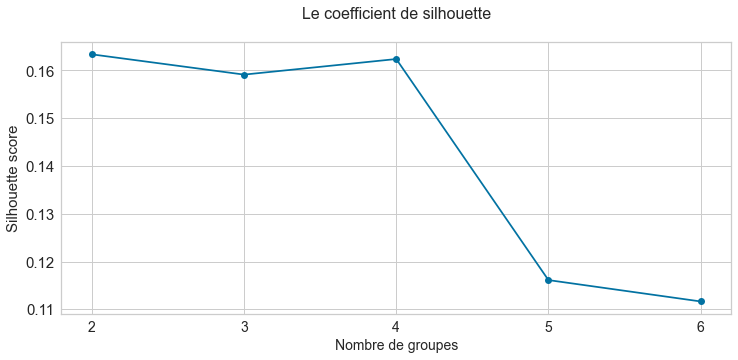

In [13]:
plt.figure(figsize=(12,5))
plt.title("Le coefficient de silhouette""\n",fontsize=16)
plt.plot([i for i in range(2,7)], km_silhouette, marker = 'o')
plt.grid(True)
plt.xlabel("Nombre de groupes",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,7)],fontsize=14)
plt.yticks(fontsize=15)
plt.savefig('the_silhouette_coefficient_method_km.png')
plt.show()

Le coefficient de silhouette est proche de O dans tous les cas. Nos groupes sont donc proches les uns des autres.

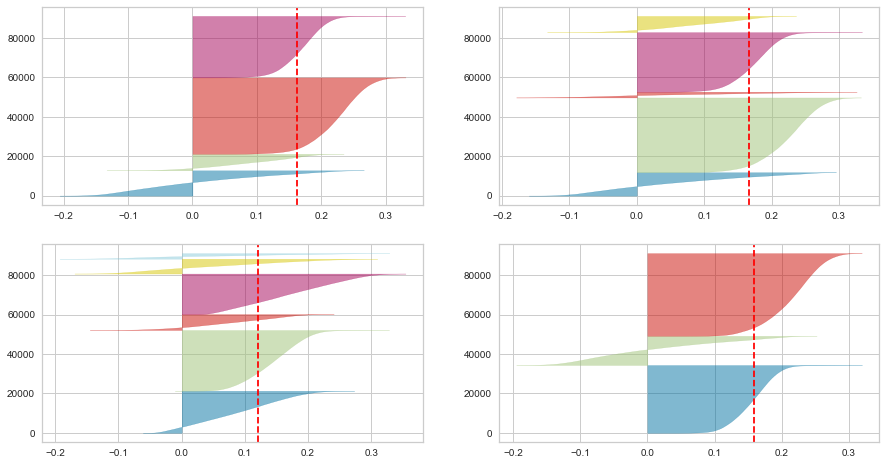

In [14]:
from yellowbrick.cluster import SilhouetteVisualizer
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [3, 4, 5, 6]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-2][mod])
    visualizer.fit(X_scaled)  

### <span class="bg-warning"> 4.1.3 Indice de Davies Bouldin<span> 
L'idée de cet indice est de comparer __les distances intra-cluster (c'est l'homogénéité)__, que l'on veut faibles, aux __distances inter-cluster (la séparation__), que l'on veut grandes.

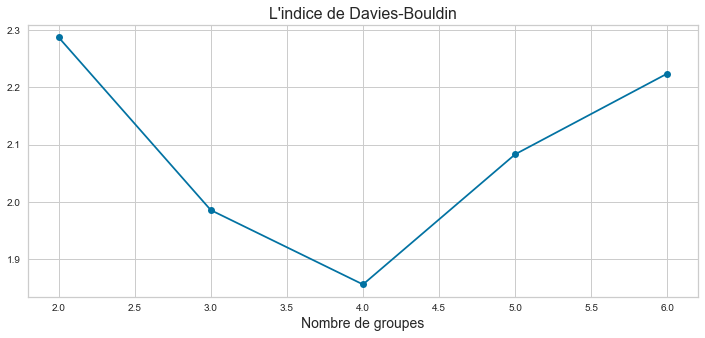

In [15]:
plt.figure(figsize=(12,5))
plt.plot([i for i in range(2,7)], db_score, marker = 'o')
plt.grid(True)
plt.xlabel('Nombre de groupes',fontsize=14)
plt.title("L'indice de Davies-Bouldin",fontsize=16 )
plt.savefig('davies_bouldin_score_km.png')
plt.show()

### <span class="bg-warning"> 4.1.4 Conclusion<span> 
__Conclusions :__ le nombre k optimal de groupes selon les différents indices :
- __Méthode du coude__ : 3 (ou 4)
- __Coefficient de silhouette__ : 4 
- __Indice de Davies Bouldin__ : 5 (ou 4)

__Nous allons donc essayer avec 3, 4 et 5 clusters__

## <span class="bg-success"> 4.2 Segmentation avec K-means<span>

### <span class="bg-warning"> 4.2.1 K means - Nombre de clusters k = 3<span>  

In [16]:
kmeans_pca_3 = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters_km_3 = kmeans_pca_3.fit(df_clients_PCA)
df_clients_PCA['Cluster3'] = kmeans_pca_3.labels_
kmeans_labels_pca_3 = kmeans_pca_3.labels_

In [17]:
pd.Series(kmeans_labels_pca_3).value_counts()

0    41630
1    34391
2    15112
dtype: int64

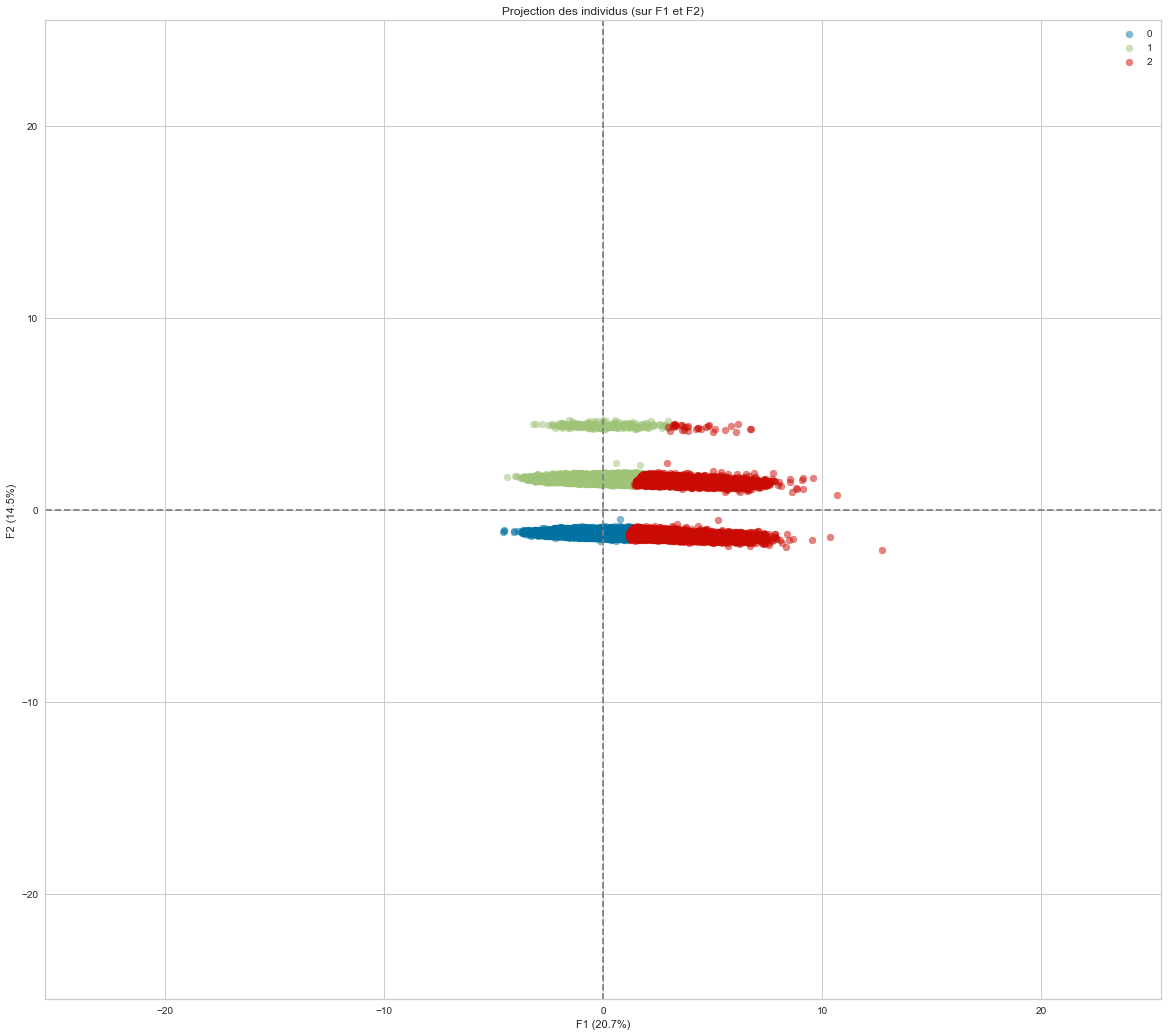

In [18]:
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = kmeans_labels_pca_3, alpha = 0.5)

### <span class="bg-warning"> 4.2.2 K means - Nombre de clusters k = 4<span>  

In [19]:
kmeans_pca_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters_km_4 = kmeans_pca_4.fit(df_clients_PCA)
df_clients_PCA['Cluster4'] = kmeans_pca_4.labels_
kmeans_labels_pca_4 = kmeans_pca_4.labels_

In [20]:
pd.Series(kmeans_labels_pca_4 ).value_counts()

0    38379
1    31112
3    13690
2     7952
dtype: int64

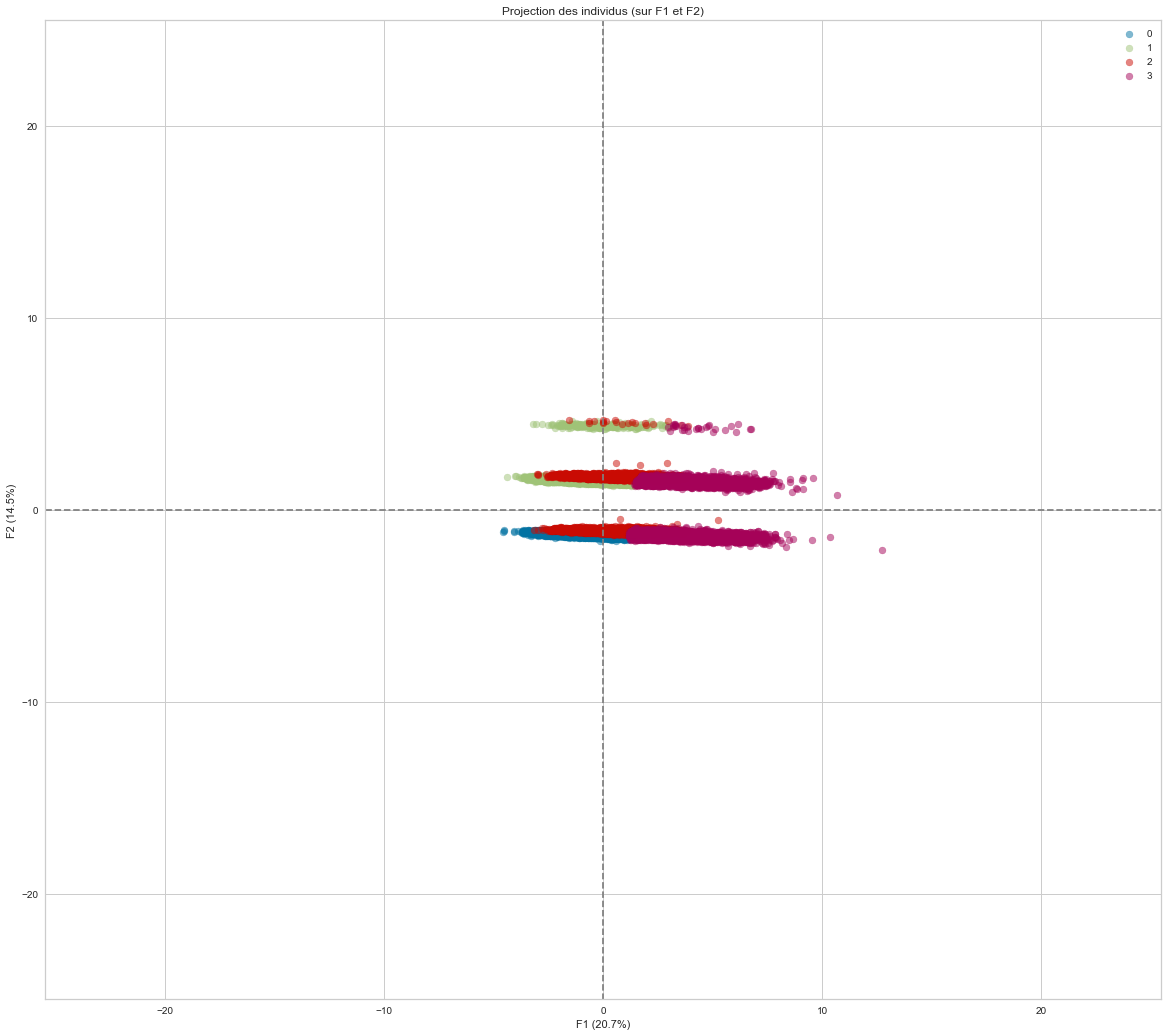

In [21]:
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = kmeans_labels_pca_4, alpha = 0.5)

### <span class="bg-warning"> 4.2.3 K means - Nombre de clusters k = 5<span> 

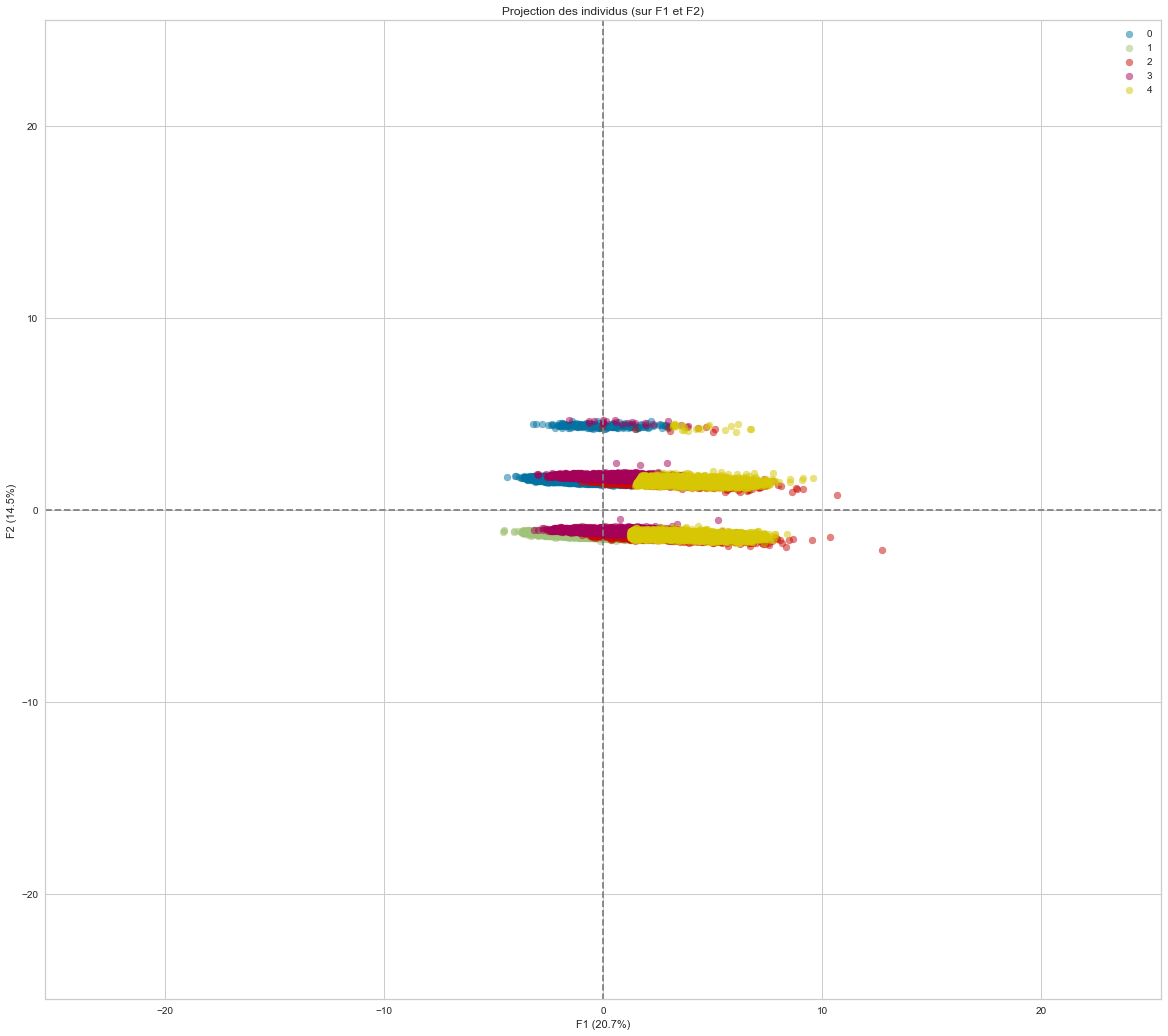

In [22]:
kmeans_pca_5 = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5 = kmeans_pca_5.fit(df_clients_PCA)
df_clients_PCA['Cluster5'] = kmeans_pca_5.labels_
kmeans_labels_pca_5 = kmeans_pca_5.labels_
PCA_NR.display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = kmeans_labels_pca_5, alpha = 0.5)

In [23]:
pd.Series(kmeans_labels_pca_5).value_counts()

1    38211
0    30787
4    12111
3     7875
2     2149
dtype: int64

## <span class="bg-info">Sauvegarde encodage avec joblib<span> 

In [25]:
encoder = StandardScaler()
#Utilisation de JobLib pour sérialiser et enregistrer l'encodage
from joblib import dump, load
# save encoding to disk
dump(encoder , 'encodageP5_saved.joblib', compress=1)

['encodageP5_saved.joblib']

## <span class="bg-info"> Sauvegarde du modèle avec joblib<span> 

In [26]:
#Utilisation de JobLib pour sérialiser et enregistrer les modèles

# save the model to disk
dump(kmeans_pca_5 , 'Kmeans_5_saved.joblib', compress=1)

['Kmeans_5_saved.joblib']

## <span class="bg-success"> 4.3 Interprétation des clusters<span> 

### <span class="bg-warning"> 4.3.1 Interprétation- K means - Nombre de clusters k = 3<span>  

### Table de données

In [27]:
df_clients.reset_index()
df_clients_PCA.reset_index();

In [28]:
# Table de données avec colonnes clusters k=3, k=4, k=5 ajoutées
df_interpretation_PCA = pd.concat([df_clients, df_clients_PCA], axis=1)
df_interpretation_PCA.shape

(91133, 26)

In [29]:
# Table de données pour interpréter la segmentation des clients pour k=3
df_interpretation_km_3 = df_interpretation_PCA.groupby('Cluster3').agg(
                                            {'récence' : 'mean', 
                                             'valeur_monétaire' : 'mean',
                                             'fréquence' : 'mean',
                                            'an_dernier_achat' : 'mean',
                                            'mois_dernier_achat' : 'median',
                                            'panier_moyen': 'mean',
                                            'facilités_paiement' : 'median'})
df_interpretation_km_3.reset_index(inplace = True)
df_interpretation_km_3.head()

,Cluster3,récence,valeur_monétaire,fréquence,an_dernier_achat,mois_dernier_achat,panier_moyen,facilités_paiement
0,0,122.65,4.50,1.14,2018.00,4,4.11,1.00
1,1,379.59,4.52,1.15,2016.99,9,4.12,1.00
2,2,228.90,6.13,1.62,2017.59,6,5.49,5.00


### Visualisation graphique

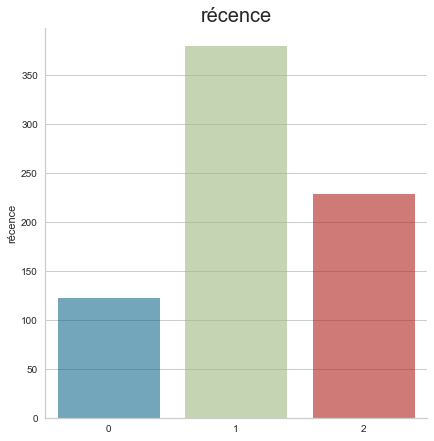

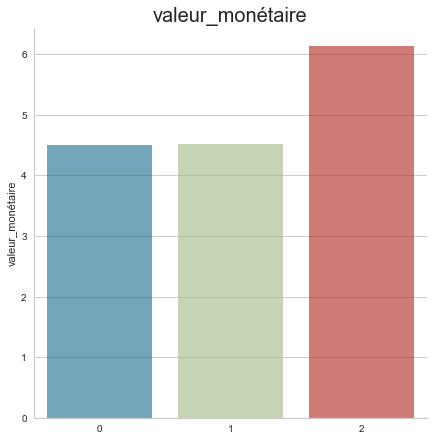

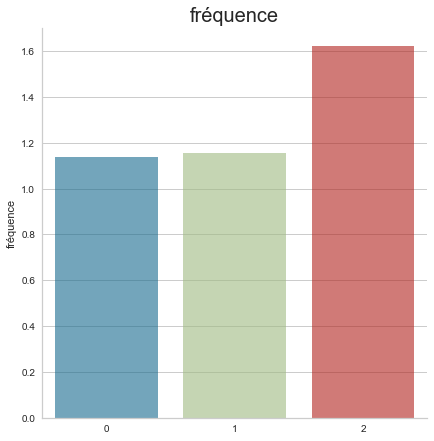

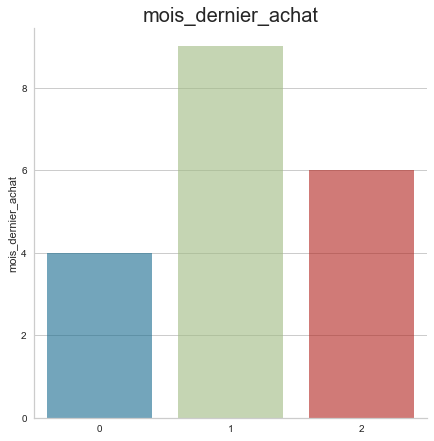

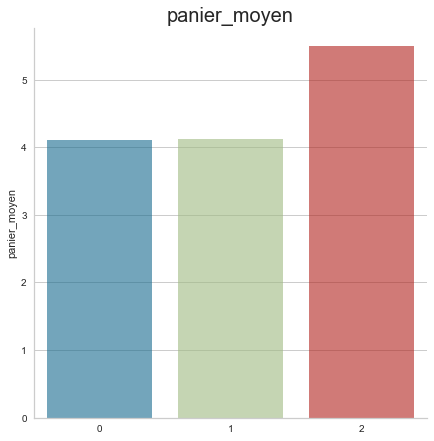

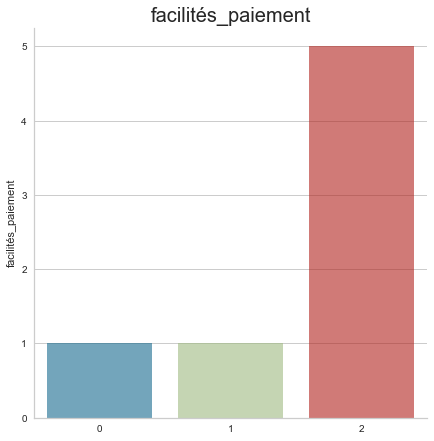

In [30]:
#Graphiques utiles à l'interprétation des clusters
colonnes = ['récence', 'valeur_monétaire', 'fréquence', 'mois_dernier_achat', 'panier_moyen', 'facilités_paiement']
for col in colonnes :
    g = sns.catplot(
    data= df_interpretation_km_3, kind="bar", x="Cluster3", y=col, ci="sd",alpha=.6, height=6)
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

### Interprétation des 3 clusters
- __cluster 0__ : Clients en voie de perdition
- __cluster 1__ : Meilleurs clients
- __cluster 2__ : Nouveaux clients

### <span class="bg-warning"> 4.3.2 Interprétation- K means - Nombre de clusters k = 4<span>  

### Table de données

In [31]:
# Table de données pour interpréter la segmentation des clients pour k=4
df_interpretation_km_4 = df_interpretation_PCA.groupby('Cluster4').agg(
                                            {'récence' : 'mean', 
                                             'valeur_monétaire' : 'mean',
                                             'fréquence' : 'mean',
                                            'mois_dernier_achat' : 'median',
                                            'panier_moyen': 'mean',
                                            'facilités_paiement' : 'median'})
df_interpretation_km_4.reset_index(inplace = True)
df_interpretation_km_4.head()

,Cluster4,récence,valeur_monétaire,fréquence,mois_dernier_achat,panier_moyen,facilités_paiement
0,0,122.32,4.49,1.14,4,4.10,1.00
1,1,379.37,4.51,1.16,9,4.12,1.00
2,2,249.54,4.82,1.15,6,4.36,2.00
3,3,229.18,6.17,1.66,6,5.52,5.50


### Visualisation graphique

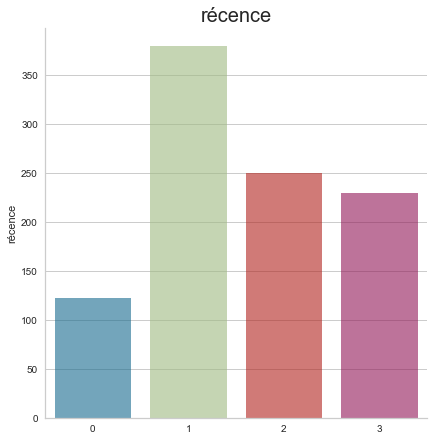

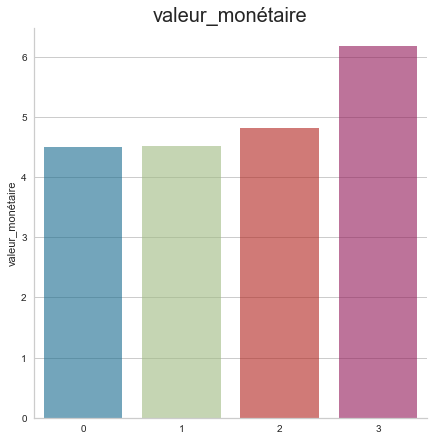

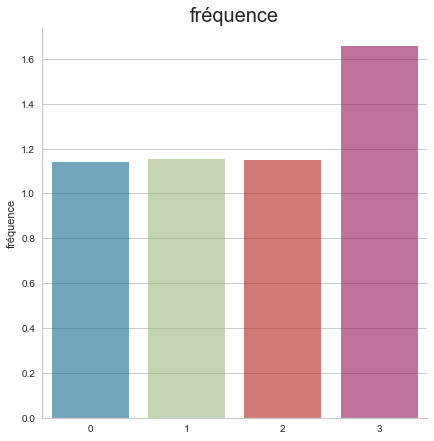

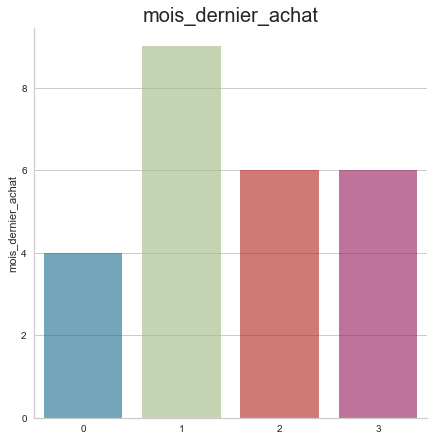

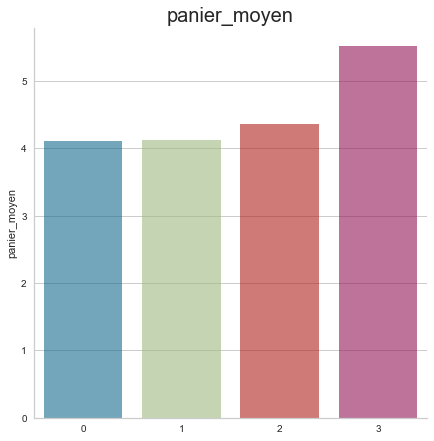

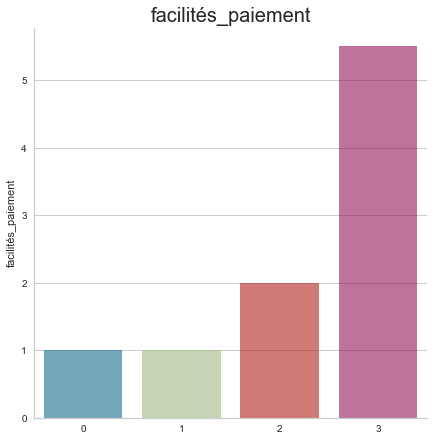

In [32]:
#Graphiques utiles à l'interprétation des clusters
colonnes = ['récence', 'valeur_monétaire', 'fréquence', 'mois_dernier_achat', 'panier_moyen', 'facilités_paiement']
for col in colonnes :
    g = sns.catplot(
    data= df_interpretation_km_4, kind="bar", x="Cluster4", y=col, ci="sd", alpha=.6, height=6)
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

### Interprétation des 4 clusters
- __cluster 0__ : Clients en voie de perdition
- __cluster 1__ : Bons clients en voie de perdition
- __cluster 2__ : Nouveaux clients
- __cluster 3__ : Meilleurs clients 

### <span class="bg-warning"> 4.3.3 Interprétation- K means - Nombre de clusters k = 5<span>  

### Table de données

In [33]:
# Table de données pour interpréter la segmentation des clients pour k=5
df_interpretation_km_5 = df_interpretation_PCA.groupby('Cluster5').agg(
                                            {'récence' : 'mean', 
                                             'valeur_monétaire' : 'mean',
                                             'fréquence' : 'mean',
                                            'mois_dernier_achat' : 'median',
                                            'panier_moyen': 'mean',
                                            'facilités_paiement' : 'median'})
df_interpretation_km_5.reset_index(inplace = True)
df_interpretation_km_5.head()

,Cluster5,récence,valeur_monétaire,fréquence,mois_dernier_achat,panier_moyen,facilités_paiement
0,0,379.44,4.50,1.12,9,4.12,1.00
1,1,122.32,4.49,1.12,4,4.11,1.00
2,2,242.40,6.76,4.64,6,4.20,2.00
3,3,249.27,4.80,1.12,6,4.36,2.00
4,4,229.53,6.05,1.25,6,5.66,6.00


### Visualisation graphique

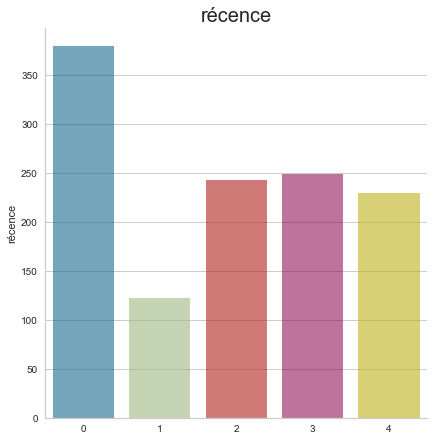

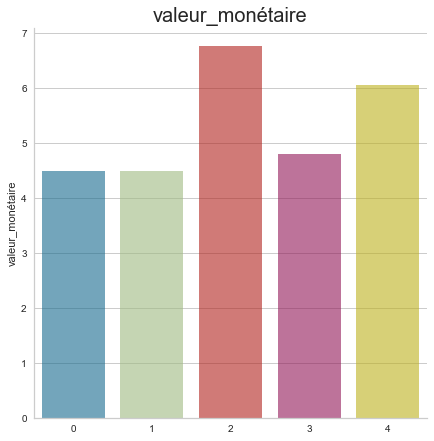

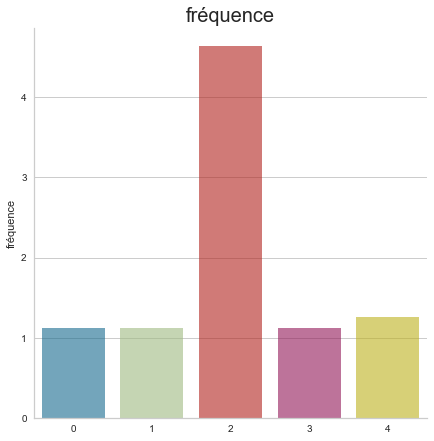

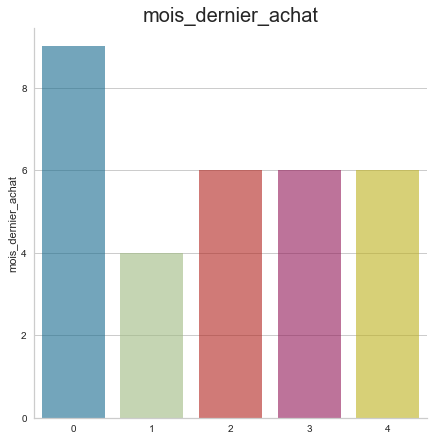

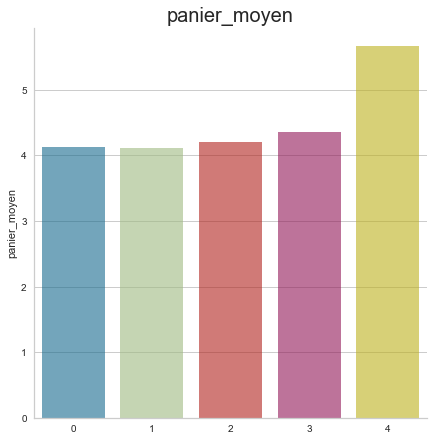

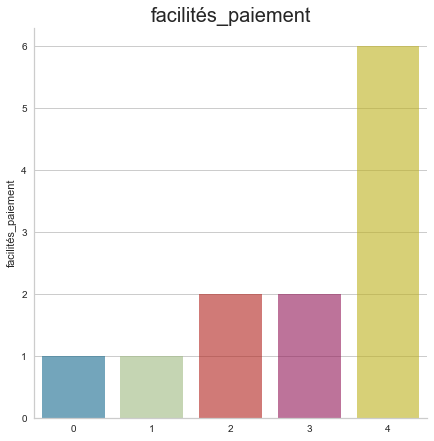

In [34]:
#Graphiques utiles à l'interprétation des clusters
colonnes = ['récence', 'valeur_monétaire', 'fréquence', 'mois_dernier_achat', 'panier_moyen', 'facilités_paiement']
for col in colonnes :
    g = sns.catplot(
    data= df_interpretation_km_5, kind="bar", x="Cluster5", y=col, ci="sd", alpha=.6, height=6)
    g.set_axis_labels("", col)
    plt.title(col, fontsize = 20)
    plt.show()

### Interprétation des 5 clusters
- __cluster 0__ : Clients en voie de perdition
- __cluster 1__ : Bons clients en voie de perdition
- __cluster 2__ : Nouveaux clients
- __cluster 3__ : Meilleurs clients fidèles 
- __cluster 4__ : Meilleurs clients qui utilisent des facilités de paiement   

## <span class="bg-success"> 4.4 Stabilité des clusters avec k-means - k = 5<span>  

In [35]:
# Chargement de la table indicateurs clients
df_clients = pd.read_csv('data_clients_olist.csv')
df_essai = df_clients.copy()

### Stabilité des clusters - 1 mois : de juillet à août 2018

In [36]:
#Création des 2 tables de comparaison de la stabilité
df_juillet = df_essai[df_essai['order_purchase_timestamp'] < '2018-07-30 15:00:37']
print(df_juillet.shape)

#On garde les clients qui étaient dans la base de données en mai
df_aout = df_essai[df_essai.customer_unique_id.isin(df_juillet.customer_unique_id)]
print(df_aout.shape)

#Suppression colonnes
colonnes_suppression = ['customer_unique_id', 'order_purchase_timestamp', 'catégorie_+_achetée', 'moyen_paiement_prefere']
df_juillet.drop(colonnes_suppression, axis = 1, inplace = True)
df_aout.drop(colonnes_suppression, axis = 1, inplace = True)

# Centrage et Réduction
#Nous mettons à l'échelle les données afin de garantir que Les unités des variables n'ont pas d'impact sur les distance
for c in df_juillet.columns:
    std_scale = StandardScaler()
    df_juillet[c] = std_scale.fit_transform(np.array(df_juillet[c]).reshape(-1, 1))

for c in df_aout.columns:
    std_scale = StandardScaler()
    df_aout[c] = std_scale.fit_transform(np.array(df_aout[c]).reshape(-1, 1))

(84479, 18)
(84479, 18)


In [37]:
# kmeans juillet
kmeans_5_juillet = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_juillet = kmeans_5_juillet.fit(df_juillet)
kmeans_labels_km_5_juillet = kmeans_5_juillet.labels_  

# kmeans aout
kmeans_5_aout = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_aout = kmeans_5_aout.fit(df_aout)
kmeans_labels_km_5_aout = kmeans_5_aout.labels_

In [38]:
#Calcul ARI
ARI_km_1_mois = metrics.adjusted_rand_score(kmeans_labels_km_5_aout, kmeans_labels_km_5_juillet)
print(ARI_km_1_mois)

#Ajout ARI dans le tableau de résultats
resultats_km = pd.DataFrame({})
resultats_km = resultats_km.append(pd.DataFrame({
    'Periode' : ['1 mois_Juillet_août'],
    'ARI' : [ARI_km_1_mois]}))
resultats_km

1.0


,Periode,ARI
0,1 mois_Juillet_août,1.00


### Stabilité des clusters - mai - août  2018 - 3 mois

In [39]:
#Création des 2 tables de comparaison de la stabilité
df_mai = df_essai[df_essai['order_purchase_timestamp'] < '2018-05-30 15:00:37']
print(df_mai.shape)

#On garde les clients qui étaient dans la base de données en mai
df_aout = df_essai[df_essai.customer_unique_id.isin(df_mai.customer_unique_id)]
print(df_aout.shape)

#Suppression colonnes
colonnes_suppression = ['customer_unique_id', 'order_purchase_timestamp', 'catégorie_+_achetée', 'moyen_paiement_prefere']
df_mai.drop(colonnes_suppression, axis = 1, inplace = True)
df_aout.drop(colonnes_suppression, axis = 1, inplace = True)

# Centrage et Réduction
#Nous mettons à l'échelle les données afin de garantir que Les unités des variables n'ont pas d'impact sur les distance
for c in df_mai.columns:
    std_scale = StandardScaler()
    df_mai[c] = std_scale.fit_transform(np.array(df_mai[c]).reshape(-1, 1))

for c in df_aout.columns:
    std_scale = StandardScaler()
    df_aout[c] = std_scale.fit_transform(np.array(df_aout[c]).reshape(-1, 1))

# kmeans mai
kmeans_5_mai = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_mai = kmeans_5_mai.fit(df_mai)
kmeans_labels_km_5_mai = kmeans_5_mai.labels_  

# kmeans aout
kmeans_5_aout = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_aout = kmeans_5_aout.fit(df_aout)
kmeans_labels_km_5_aout = kmeans_5_aout.labels_

#Calcul ARI
ARI_km_3_mois = metrics.adjusted_rand_score(kmeans_labels_km_5_aout, kmeans_labels_km_5_mai)
print(ARI_km_3_mois)

#Ajout ARI dans le tableau de résultats
resultats_km = resultats_km.append(pd.DataFrame({
    'Periode' : ['3 mois_Mai_août'],
    'ARI' : [ARI_km_3_mois]}))
resultats_km

(72839, 18)
(72839, 18)
1.0


,Periode,ARI
0,1 mois_Juillet_août,1.00
0,3 mois_Mai_août,1.00


### Stabilité des clusters - mars - août  2018 - 6 mois

In [40]:
#Création des 2 tables de comparaison de la stabilité
df_mars = df_essai[df_essai['order_purchase_timestamp'] < '2018-03-30 15:00:37']
print(df_mars.shape)

#On garde les clients qui étaient dans la base de données en mars
df_aout = df_essai[df_essai.customer_unique_id.isin(df_mars.customer_unique_id)]
print(df_aout.shape)

#Suppression colonnes
colonnes_suppression = ['customer_unique_id', 'order_purchase_timestamp', 'catégorie_+_achetée', 'moyen_paiement_prefere']
df_mars.drop(colonnes_suppression, axis = 1, inplace = True)
df_aout.drop(colonnes_suppression, axis = 1, inplace = True)

# Centrage et Réduction
#Nous mettons à l'échelle les données afin de garantir que Les unités des variables n'ont pas d'impact sur les distance
for c in df_mars.columns:
    std_scale = StandardScaler()
    df_mars[c] = std_scale.fit_transform(np.array(df_mars[c]).reshape(-1, 1))

for c in df_aout.columns:
    std_scale = StandardScaler()
    df_aout[c] = std_scale.fit_transform(np.array(df_aout[c]).reshape(-1, 1))

# kmeans mars
kmeans_5_mars = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_mars = kmeans_5_mars.fit(df_mars)
kmeans_labels_km_5_mars = kmeans_5_mars.labels_  

# kmeans aout
kmeans_5_aout = KMeans(n_clusters=5, init='k-means++', random_state=42)
clusters_km_5_aout = kmeans_5_aout.fit(df_aout)
kmeans_labels_km_5_aout = kmeans_5_aout.labels_

#Calcul ARI
ARI_km_6_mois = metrics.adjusted_rand_score(kmeans_labels_km_5_aout, kmeans_labels_km_5_mars)
print(ARI_km_6_mois)

#Ajout ARI dans le tableau de résultats
resultats_km = resultats_km.append(pd.DataFrame({
    'Periode' : ['6 mois_Mars_août'],
    'ARI' : [ARI_km_6_mois]}))
resultats_km

(59772, 18)
(59772, 18)
1.0


,Periode,ARI
0,1 mois_Juillet_août,1.00
0,3 mois_Mai_août,1.00
0,6 mois_Mars_août,1.00


## <span class="bg-info"> 5. ACP - Classification hiérarchique ascendante<span>

Pour des problèmes de mémoires (calculs très lourds), nous ne testerons la classification hierarchique ascendante que sur __un nachantillon de 10 000 clients.__

In [41]:
# préparation des données pour le clustering
data_reduce = df_clients_PCA.sample(10000, random_state=1).copy()
X = data_reduce.values
names = data_reduce.index

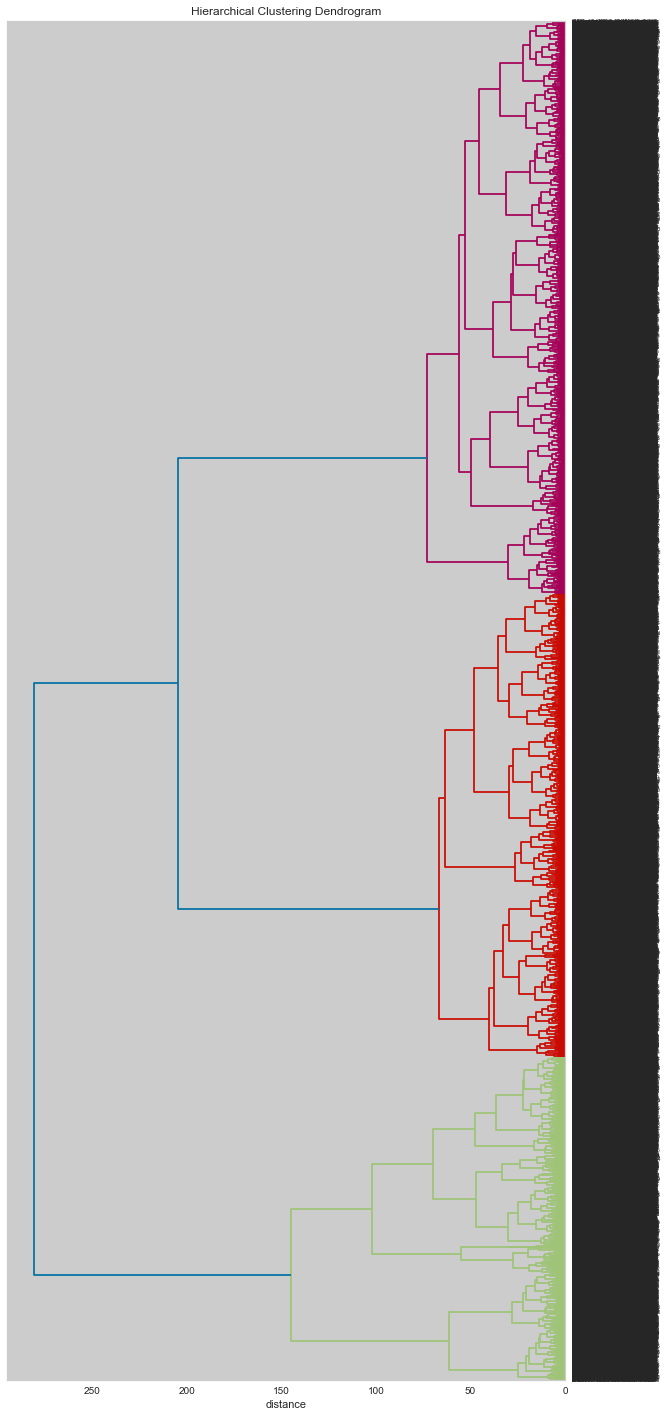

In [42]:
from scipy.cluster.hierarchy import linkage, fcluster
# Clustering hiérarchique
Z = linkage(X, 'ward')

# Affichage du dendrogramme
PCA_NR.plot_dendrogram(Z, names)

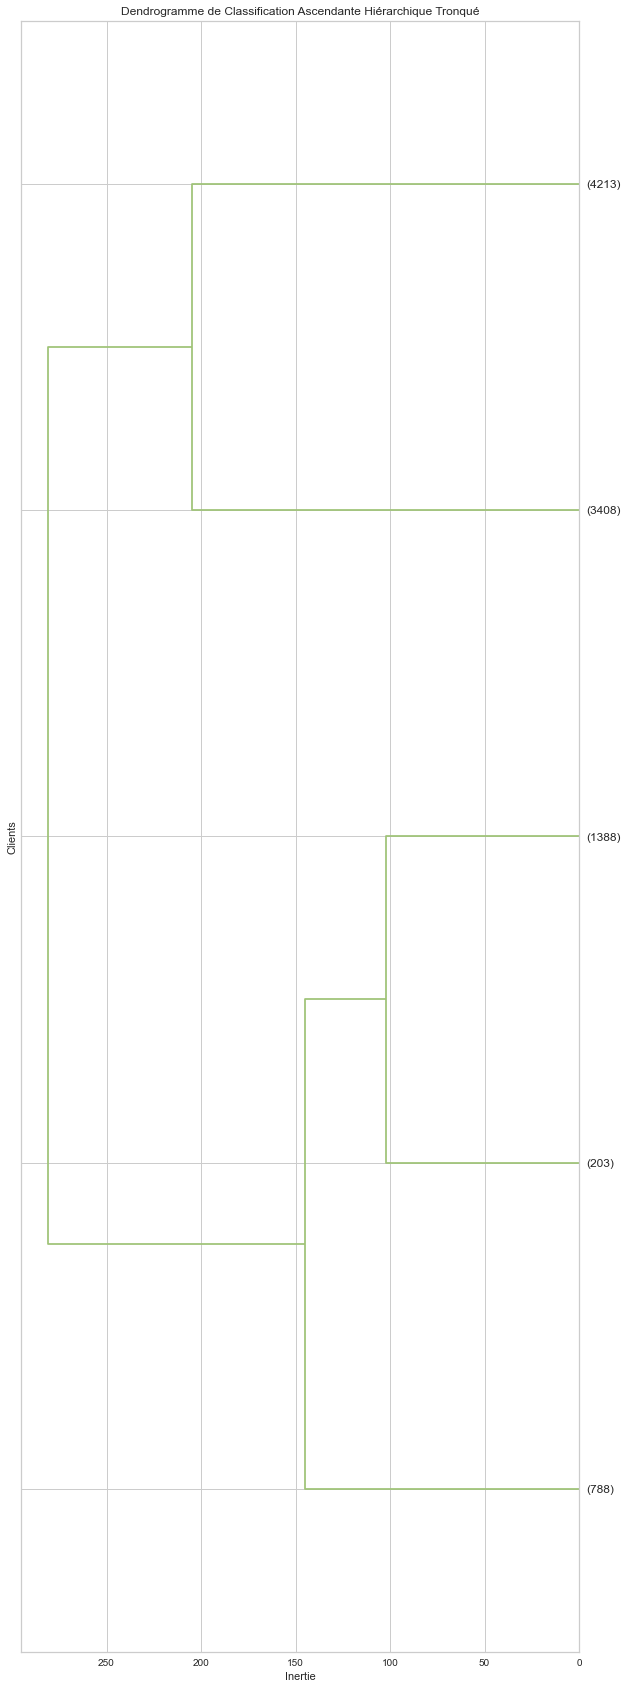

In [43]:
plt.figure(figsize=(10,30))
plt.title('Dendrogramme de Classification Ascendante Hiérarchique Tronqué')
plt.xlabel("Inertie")
plt.ylabel('Clients')
truncate_dendro = sch.dendrogram(Z,labels =  names,color_threshold=1200, orientation='left', p=5, truncate_mode='lastp')
plt.show(truncate_dendro)